In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

# Neural stuff

In [2]:
sigm = lambda x: 1/(1+np.exp(-x))

In [3]:
class Layer:
    
    
    def __init__(self,NC,NN,ActFun,rate=1.1): # Jugar con la tasa de mutacion
        
        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate
        
        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )
        
    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]
    
    def Mutate(self):
    
        #self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        #self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))
        
        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))
    
    def Getinf(self):
        return (self.W, self.b)

In [4]:
def GetBrain():
    l0 = Layer(1,5,sigm)
    l1 = Layer(5,1,sigm)
    #l2 = Layer(2,1,sigm)
    Brain = [l0,l1]
    return Brain    

# Estructura del individuo

In [5]:
class Robot:
    
    def __init__(self, dt, Layers, Id=0):
        
        self.Id = Id
        self.dt = dt
        
        
        self.r = np.random.uniform([0.,0.])
        theta = 0.
        self.v = np.array([1.*np.cos(theta),1.*np.sin(theta)])
        
        # Capacidad o aptitud del individuo
        self.Fitness = np.inf
        self.Steps = 0
        

        # Brain
        self.Layers = Layers
        
    def GetR(self):
        return self.r
    
    def Evolution(self):
        self.r += self.v*self.dt # Euler integration (Metodos 2)
        
        # Cada generación regreamos el robot al origin
        # Y volvemos a estimar su fitness
    def Reset(self):
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf    
        
    # Aca debes definir que es mejorar en tu proceso evolutivo
    def SetFitness(self):
        self.Fitness = 1/(1+self.Steps)
        
     
       # Brain stuff
    def BrainActivation(self,x,threshold=0.7): 
        # El umbral (threshold) cerebral es a tu gusto!
        # cercano a 1 es exigente
        # cercano a 0 es sindrome de down
        
        # Forward pass - la infomación fluye por el modelo hacia adelante
        for i in range(len(self.Layers)):         
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)
        
        self.Activation = np.round(output,4)
    
        # Cambiamos el vector velocidad
        if self.Activation[0] > threshold:
            self.v = -self.v
        else:
            self.Steps += 1
            
            # Deberias penalizar de alguna forma, dado que mucha activación es desgastante!
            # Para cualquier cerebro
    
        return self.Activation
    
    # Aca mutamos (cambiar de parametros) para poder "aprender"
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()
    
    # Devolvemos la red neuronal ya entrenada
    def GetBrain(self):
        return self.Layers
    
    def GetSteps(self):
        return self.Steps

In [6]:
def GetRobots(N):
    
    Robots = []
    
    for i in range(N):
        
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)
        
    return Robots

In [7]:
dt = 0.1
t = np.arange(0.,5.,dt)
Robots = GetRobots(10)

In [8]:
def GetPlot():
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
 
    return ax,ax1

# Time evolution

In [9]:
def TimeEvolution(Robots,e,Plot=True):
    
  
    for it in range(t.shape[0]):
        
        if Plot:
        
            clear_output(wait=True)
        
            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)
        
            ax.set_title('t = {:.3f}'.format(t[it]))
        
        Activation = np.zeros(len(Robots))
        
        for i,p in enumerate(Robots):
            p.Evolution()
         
            # Activacion cerebral
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            # Region donde aumentamos los pasos para el fitness
            if  p.GetR()[0] >=-1 and p.GetR()[0]<=1:
                p.Steps += 1   
                
            if Plot and i < 5: # Solo pintamos los primeros 5, por tiempo de computo
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
                
        # Pintamos la activaciones de los primeros 5
        
        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')
        
        if Plot:
        
            ax.legend(loc=0)  
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

# Algoritmo evolutivo

In [10]:
# Definimos la rutina de entrenamiento
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):
    
    # Porcentaje de robots elegidos en cada epoch
    N = int(0.7*len(Robots))
    
    FitVector = np.array([])
    
    
    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)
    
    for e in range(int(epochs)):
        
        # Reiniciamos y mutamos los pesos
        
        for p in Robots:
            p.Reset() 
            p.Mutate()
            
        # Evolucionamos
        TimeEvolution(Robots,e,Plottime) # Apagar dibujar la evolución para entrenar
        
        # Actualizamos fitness de cada robot
        for i,p in enumerate(Robots):
            p.SetFitness()
        
        # Aca va toda la rutina de ordenar los bots del más apto al menos apto
        
        # Elegir los más aptos
        scores = [(p.Fitness,p) for p in Robots]
        scores.sort(key = lambda x: x[0], reverse = False)         

        # Hacer la copia profunda del objeto
        for i,r in enumerate(Robots):
            j = i%N
            Robots[i] = copy.deepcopy(scores[j][1])   #Cambio de Temp[j] por "scores[j][1]"
        
        # Elegir el bot con la mejor aptitud
        # es el primero dado que se ordeno
        best_fitness = scores[0][0]
        best_bot = scores[0][1]
        
        
        # LLenar como cambia el fitness durante el proceso
        # Si está aprendiendo debería disminuir !!!
        FitVector = np.append(FitVector, best_fitness )
        
        
        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])
        
        clear_output(wait=True)
        
        print('Epoch:', e)
                
        # Last fitness
        print('Last Fitness:', FitVector[-1])  
        
        
        if Plot:
            
            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.75,ls='--',color='r',label='Threshold')
            
            ax1.set_title('Fitness')
            ax1.plot(FitVector)
        
            ax.legend(loc=0)
            
            plt.show()
            
            time.sleep(0.01)
        
        
    
    return best_bot, FitVector

Epoch: 199
Last Fitness: 0.01020408163265306


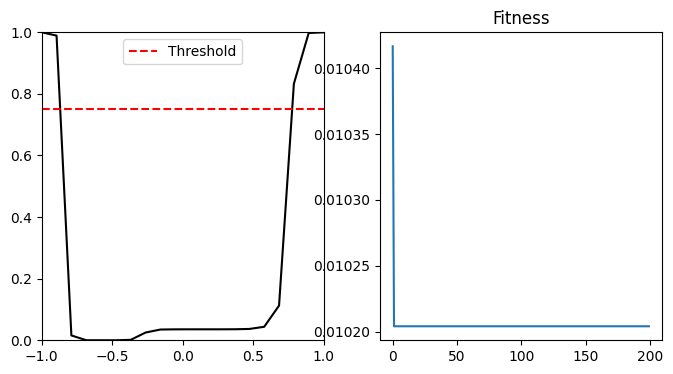

In [11]:
Robots = GetRobots(20)
Best, FitVector = Genetic(Robots,Plot=True,Plottime=False) # Apagar Plottime para el entrenamiento

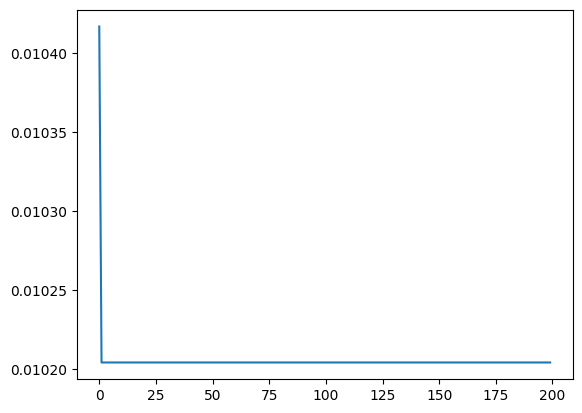

In [12]:
plt.plot(FitVector)

# Testeo mejor robot

In [13]:
Brain = Best.GetBrain()
l1 = Brain[0].Getinf()
l2 = Brain[1].Getinf()

In [14]:
print("Pesos de la capa oculta:",l1[0])
print("Sesgos de la capa oculta:",l1[1])

Pesos de la capa oculta: [[-17.48044259 -18.06880005  17.45314873  27.76830105  -0.56214882]]
Sesgos de la capa oculta: [[-14.84318898  21.12647095 -14.02549667  10.07937348 -12.31484785]]


In [15]:
print("Pesos de la capa salida:",l2[0])
print("Sesgo de la capa salida:",l2[1])

Pesos de la capa salida: [[ 20.2029042 ]
 [-19.18908871]
 [ 11.13823224]
 [  6.10621173]
 [  1.83953961]]
Sesgo de la capa salida: [[9.78273342]]


In [16]:
dt = 0.1
t = np.arange(0.,15.,dt)      #Se eligio t = 15 seg para la prueba

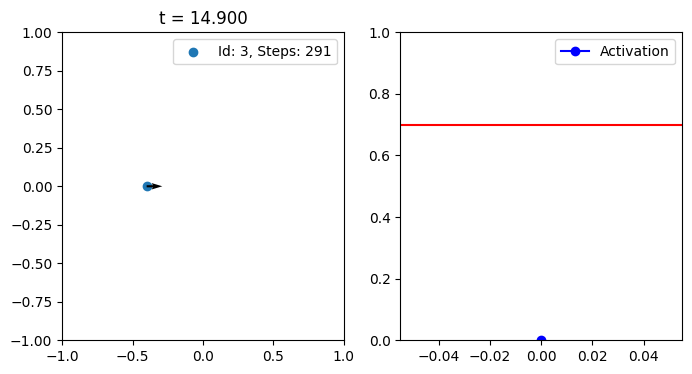

In [17]:
Best.Reset() 
TimeEvolution([Best],1)